# Проект по предсказанию токсичности соединений
Что нужно сделать:


1. Проанализировать данные, + за визуализацию
2. Предобработать данные, чтобы улучшить качество модели. + за инсайты, если что-то найдется
3. Обучить модель и провалидировать ее. Метрика: RMSE
4. Проверить модель на test данных и прислать результаты вместе с ноутбуком



## Библиотеки и загрузка данных

rdkit – библиотека для работы с химическими данными.

In [3]:
!pip3 install rdkit

In [4]:

import pandas as pd
import numpy as np
from IPython.display import display # for color differentiation of annotations and documentation

# working with charts
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
train = pd.read_csv("./train.csv")

In [6]:
train.head()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


In [7]:
test = pd.read_csv("./test_only_smiles.csv")
test.head()


,Unnamed: 0,SMILES
0,0,CC(O)CCO
1,1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,3,C=CC(=O)NCNC(=O)C=C
4,4,CC1=CC(=CC=C1)[N+]([O-])=O


## Анализ данных

#### 1) Проведем детальный анализ имеющихся данных 
Cмотрим структуру, типы признаков

In [8]:
train.info()
display(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


SMILES      0
activity    0
dtype: int64

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  253 non-null    int64 
 1   SMILES      253 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB


- NAN нет
- нулей нет
- у столбцов SMILES "проблемный" формат - object. Который не подходит для машинного обучения -> надо преобразовывать.
- у колонки activity Dtype с плавающей точкой подходит для дальнейшей работы.

#### 2) Выявляем выбросы и анамалии.

Т.к действие это выполнялось в ранних проектах, воспользуюсь ранее написанной функцией

In [10]:
def box_histplot(data: pd.DataFrame, column: str):
    """
    Создается коробочная диаграмма и гистограмма для указанного столбца во фрейме данных, игнорируя строки с нулевыми значениями.
    
    Параметры:
    - данные: фрейм данных pandas, содержащий данные
    - столбец: строка, название столбца для построения графика
    
    Возвращается:
    - Нет (отображает график)
    """
    
       
    # Create the boxplot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    histplot = sns.histplot(data=data, x=column, ax=axes[0])
    histplot.set_title(f"Histplot for {column} (Cleaned Full Square Distribution)")
    boxplot = sns.boxplot(data=data, x=column, ax=axes[1])
    boxplot.set_title(f"Boxplot for {column}")
    plt.show()


     

def outliers_iqr(data: pd.DataFrame,  column: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Определяет и выделяет выбросы из набора данных, используя метод IQR (межквартильный диапазон).
    
    Параметры:
    - - данные (pd.DataFrame): входной фрейм данных, содержащий данные.
    - - столбец (str): имя столбца во фрейме данных для анализа на наличие выбросов.
    
    Возвращается:
    - кортеж[pd.DataFrame, pd.DataFrame данных]: Кортеж, содержащий два фрейма данных:
        - - Первый фрейм данных содержит строки с выбросами.
        - - Второй фрейм данных содержит строки без выбросов (очищенные данные).
    """
    
    x = data[column]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    
    # Determine the lower and upper bounds for identifying outliers
    lower_bound = quartile_1 - (iqr * 1.5)  
    upper_bound = quartile_3 + (iqr * 1.5)  
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

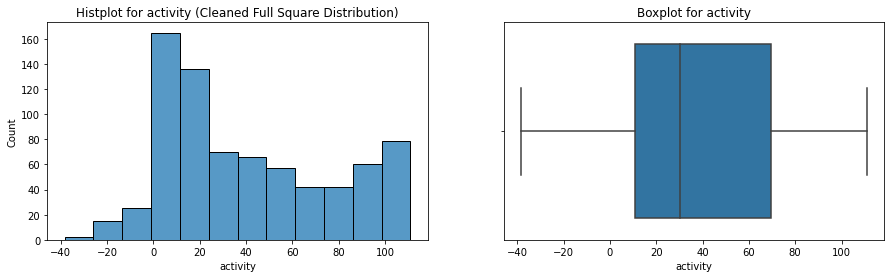

Empty DataFrame
Columns: [SMILES, activity]
Index: []
Total outliers - 0


In [11]:
box_histplot(train, 'activity')
outliers, cleaned = outliers_iqr(train, 'activity')
print (outliers)
print (f'Total outliers - {outliers.shape[0]}')

Для корректной оценки выбросов, рассмотрим теоретическую основу параметра "activity"
Итог поисков, это или:
1) «Protein binding potency GSH»
Основан на взаимодействии химических веществ с белками по механизмам: SN2 и присоединение по Михаэлю; основан на эмпирических данных о реакционной способности тиолов, выраженной значением RC50 in Chemico; выделено 137 структурных категорий, разделенных на 5 групп по активности:
- чрезвычайно реактивная (RC50 <0,099 ммоль/л);
- высоко реактивная (RC50 = 0,100 – 0,990 ммоль/л);
- умеренно реактивная (RC50 = 1,000, этап 15,000 ммоль/л);
- слабореактивная (RC50 = 16,000 – 70,000 ммоль/л);
- сомнительная (RC50 = 71,000 – 135,000 ммоль/л).

2) Константы заместителей
Это из QSAR. Это константы заместителей вошли в практику QSAR после появления уравнения Ганча-Фуджиты, связывающего биологическую активность с константами заместителей и значением липофильности.

3) ИИ отправил меня на сайт проекта Tox21.gov Но похожей баз данных я не нашла, данное предположение источника - сомнительное и не отвечает на мой вопрос.

Т.к документации к датасету нет, я не могу понять какие параметры токсичности применять? Отрицательные значения говорят о токсичности? Или наоборот? 

Принимаю решение предсказать пока только активность, цель определить токсичность - игнорируем.

Таким образом - выбросов не обнаружено.

#### 3) Определить вид распределения

Исходя из графиков выше, можно сказать что признак "activity" не имеет нормального распределения. Давайте узнаем какое же оно.


In [12]:
import scipy.stats as stats
import numpy as np

In [13]:
activity = train['activity']

# Fit different distributions
distributions = ['norm', 'lognorm', 'expon', 'beta', 'gamma']
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(activity)
    ks_stat, p_value = stats.kstest(activity, dist_name, args=params)
    print(f"{dist_name} - KS test p-value: {p_value:.9f}")

norm - KS test p-value: 0.000000000
lognorm - KS test p-value: 0.000000000
expon - KS test p-value: 0.000000000
beta - KS test p-value: 0.000000000
gamma - KS test p-value: 0.000001121


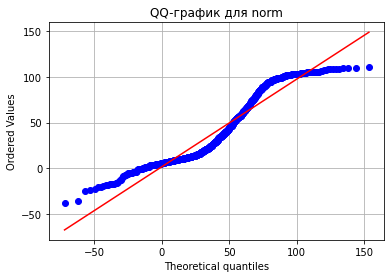

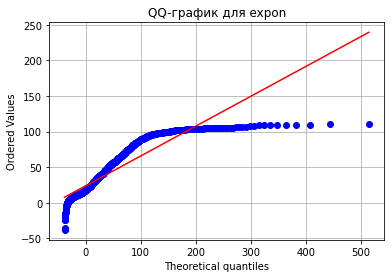

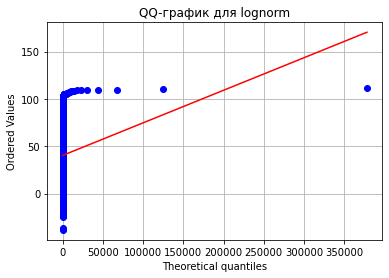

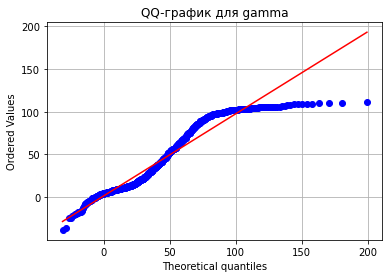

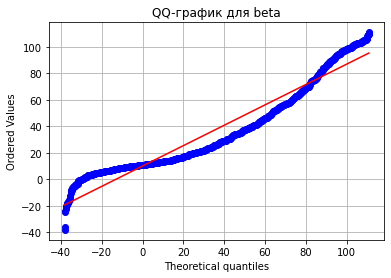

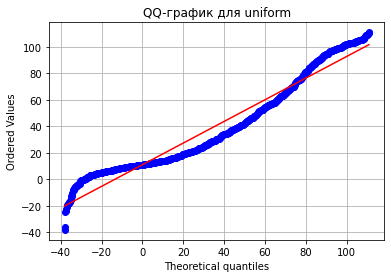

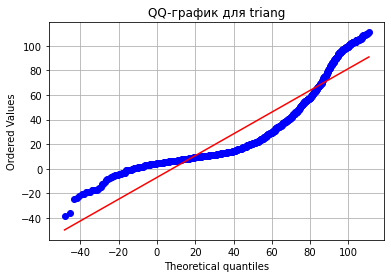

In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings

data = train['activity'].values  

distributions_to_check = ['norm', 'expon', 'lognorm', 'gamma', 'beta', 'uniform', 'triang']

for dist_name in distributions_to_check:
    dist = getattr(stats, dist_name)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        try:
            params = dist.fit(data)
            stats.probplot(data, dist=dist, sparams=params, plot=plt)
            plt.title(f"QQ-график для {dist_name}")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"{dist_name} не удалось подогнать: {e}")

Исходя из QQ графиков, распределение категориального признака либо гамма, либо непрерывное равномерное. Но гамма использовать я не могу, ибо нули или отрицательные значения недопустимы, потому что гамма-распределение определено только для положительных чисел.

Таким образом в дальнейшем опираемся на непрерывное равномерное распределение.


## Предобработка данных

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem

SMILES – это форма записи молекулы текстом. Модели не понимают текст (если мы не говорим о специальных моделях), поэтому текст нужно превратить в числа. Один из способов превратить молекулы в числа – это fingerprints.

In [16]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
def smiles_to_fp(smiles_list, radius=2, nBits=1024):
    '''Convert SMILES to Morgan fingerprints using MorganGenerator (recommended approach)'''
    generator = GetMorganGenerator(radius=radius, fpSize=nBits)
    fingerprints = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            fp = generator.GetFingerprint(mol)
            fingerprints.append(np.array(fp))
        else:
            # Обработка ошибочной строки (можно заменить на нули или выбросить)
            fingerprints.append(np.zeros(nBits, dtype=int))

    return np.array(fingerprints)

# Преобразование SMILES из train
X_train = smiles_to_fp(train.SMILES)

# Преобразование SMILES из test
X_test = smiles_to_fp(test.SMILES)


Я получила матрицу признаков: X_train — это numpy.ndarray размерности (N, 1024)
где N — количество строк (молекул), а 1024 — размерность фингерпринта.

Так как выбросов мы не обнаружили, предобработка "activity" не требуется.

## Обучение модели

In [17]:
activity = train['activity']


#### 1) Random Forest Regressor

In [18]:
from sklearn.ensemble import RandomForestRegressor


In [19]:
model_RandomForest = RandomForestRegressor()
model_RandomForest.fit(X_train, train.activity)
y_pred_RandomForest = model_RandomForest.predict(X_test)

#### 2) XGBoost (Градиентный бустинг)

In [ ]:
#Удаляю потом снова скачиваю, так как при повтороном запуске
#блокнота вылезает ошибка установки.
!pip uninstall xgboost -y
!pip cache purge

Files removed: 6 (79 kB)


In [ ]:
!sudo -H pip install --upgrade pip
!pip install --upgrade pip
!pip install xgboost==2.1.4

"sudo" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


   ---------------------------------------- 1.8/1.8 MB 529.3 kB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
c:\pyton\python.exe -m pip install --upgrade pip


  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.4-py3-none-win_amd64.whl (124.9 MB)


In [29]:
from xgboost import XGBRegressor
model_xgboost = XGBRegressor()
model_xgboost.fit(X_train, activity)
y_pred_xgboost = model_xgboost.predict(X_test)

#### 3) Support Vector Regression (SVR)

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [31]:
# Масштабируем признаки
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

# Создаём и обучаем SVR (ядро RBF — хорошее универсальное решение)
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_tr_scaled, activity)

# Делаем предсказания на тесте
y_pred_SVR = model.predict(X_te_scaled)


## Валидация

### Оценим качество обученных моделей


- Я не могу посчитать меторики качества на test, т.к там нет значений "activity"
- Создаю еще одну тестовую выборку для оценки метрик.


#### 1) Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_train — вектор активности из train
y_train = train.activity.values

# Разделяем train на обучающую и валидационную выборки (например, 80/20)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, activity, test_size=0.2, random_state=42
)

# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(random_state=42)
model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")


Валидация на hold-out части train:
MSE: 594.5929
RMSE: 24.3843
MAE: 18.8686
R2: 0.5376


#### 2) XGBoost

In [33]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Создаём и обучаем модель на обучающей части
model_xgboost = XGBRegressor(random_state=42)
model_xgboost.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_xgboost.predict(X_val)

# Оцениваем качество модели
print("Валидация XGBRegressor на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")



Валидация XGBRegressor на hold-out части train:
MSE: 643.8240
RMSE: 25.3737
MAE: 19.1403
R2: 0.4993


#### 3) SVR

In [34]:
# Масштабируем признаки на обучающей выборке и применяем масштабирование к валидационной
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

# Создаём и обучаем модель SVR на обучающей части
model_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model_svr.fit(X_tr_scaled, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_svr.predict(X_val_scaled)

# Оцениваем качество модели
print("Валидация SVR на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")



Валидация SVR на hold-out части train:
MSE: 1311.5036
RMSE: 36.2147
MAE: 29.3163
R2: -0.0200


Исходя из метрик:
1) Лушая (наименьшая) RMSE у RandomForest. 
2) Модель объяснет только 53,76% дисперсии в данных. Не густо, но цифра привычная для химических задач. 

Попробуем оптимизировать и повысить показатели.

# Улучшение показателей 

### - Изменим количество деревьев

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Разбиваем данные на train и validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

n_estimators_range = range(10, 501, 10)  # Проверяем от 10 до 500 деревьев с шагом 10
rmse_list = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)



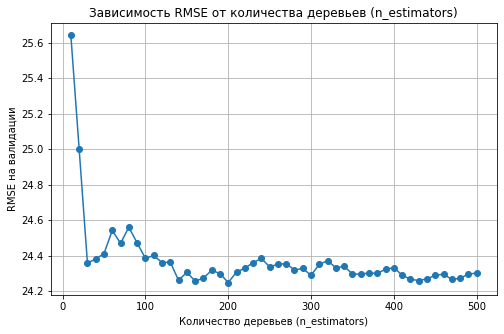

In [41]:
# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, rmse_list, marker='o')
plt.title('Зависимость RMSE от количества деревьев (n_estimators)')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('RMSE на валидации')
plt.grid(True)
plt.show()

Исходя из графика можно сделать вывод, что стоит зафиксировать n_estimators = 200. Это самый оптимальный вариант.

Опробуем.

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(n_estimators=200,random_state=42)
model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")

Валидация на hold-out части train:
MSE: 587.9575
RMSE: 24.2478
MAE: 18.7317
R2: 0.5427


Напомню, как выглядили показатели ранее:

MSE: 594.5929

RMSE: 24.3843

MAE: 18.8686

R2: 0.5376

RMSE - снизился, что является улучшением модели. Модель теперь ошибается на 24.25 единицы активности.

MAE - снизился, что является улучшением модели. Средняя ошибка составляет 18,73

R2 - повысился, что является улучшением модели. 54,27% дисперсии в данных объясняется моделью.

### - Ограничим глубину деревьев

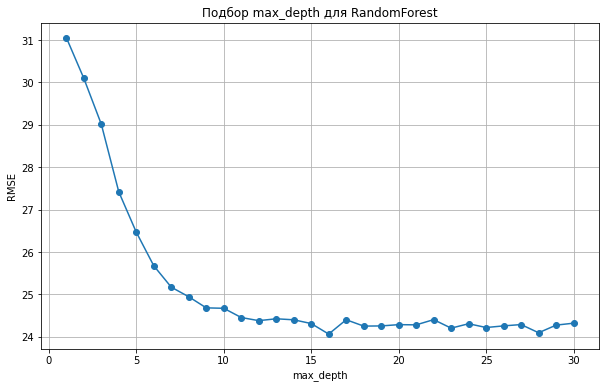

Лучший max_depth: 16, RMSE: 24.0643


In [44]:
depths = list(range(1, 31))  # Перебираем max_depth от 1 до 30
rmse_scores = []

for d in depths:
    model = RandomForestRegressor(max_depth=d, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(depths, rmse_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Подбор max_depth для RandomForest')
plt.grid(True)
plt.show()

# Лучшее значение
best_depth = depths[np.argmin(rmse_scores)]
print(f"Лучший max_depth: {best_depth}, RMSE: {min(rmse_scores):.4f}")


### - С помощью GridSearchCV подберем остальные параметры (регуляризация)

In [45]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [46]:
# Сетка параметров для перебора
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Создание модели
rf = RandomForestRegressor(random_state=42)

# Поиск по сетке
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3,
                           n_jobs=-1, verbose=2)

grid_search.fit(X_tr, y_tr)

# Лучшая модель
best_model = grid_search.best_estimator_

print(f"Лучшие параметры: {grid_search.best_params_}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Лучшие параметры: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


Объединим посчитанные параметры:

In [47]:
# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 16,
    max_features = 'sqrt',
    random_state = 42,
    min_samples_leaf = 1,
    min_samples_split = 2)

model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")

Валидация на hold-out части train:
MSE: 709.5318
RMSE: 26.6370
MAE: 22.2125
R2: 0.4482


Результраты критично ухудшились. Воспользуемся RandomizedSearchCV

In [48]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Случайная сетка параметров
param_dist = {
    'n_estimators': randint(100, 500),          # Кол-во деревьев
    'max_depth': randint(5, 30),                # Максимальная глубина дерева
    'min_samples_split': randint(2, 20),        # Мин. число объектов для разбиения
    'min_samples_leaf': randint(1, 10),         # Мин. число объектов в листе
    'max_features': ['sqrt', 'log2', None],     # Кол-во признаков при разбиении
    'bootstrap': [True, False]                  # Использовать бэггинг или нет
}

# Модель
rf = RandomForestRegressor(random_state=42)

# Поиск по случайной сетке
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 
    cv=3,
    verbose=2,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Обучение
random_search.fit(X_tr, y_tr)

# Лучшая модель
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val)

# Вывод результатов
print(f"Лучшие параметры: {random_search.best_params_}")



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'bootstrap': False, 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 403}


Попробуем

In [49]:
# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(
    n_estimators = 403,
    max_depth = 29,
    max_features = 'sqrt',
    bootstrap = False,
    random_state = 42,
    min_samples_leaf = 2,
    min_samples_split = 2)

model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")

Валидация на hold-out части train:
MSE: 639.3130
RMSE: 25.2846
MAE: 20.6675
R2: 0.5028


Напомню, что все еще лучшим результатом были показатели: 
MSE: 587.9575
RMSE: 24.2478
MAE: 18.7317
R2: 0.5427

Таким образом, я останаовилась на таких параметрах:
n_estimators=200,
random_state=42,
max_depth = 16

При наличии бОльшего свободного времени попробовала бы поварьировать результаты в ручную.

In [50]:
# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 16,
    random_state = 42)

model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")


Валидация на hold-out части train:
MSE: 580.9529
RMSE: 24.1030
MAE: 18.8770
R2: 0.5482


Чууууток улучшили результат. Я на этом остановлюсь.

# Предсказываем активность

In [51]:
# Обучаем модель на всём обучающем наборе
model_RandomForest = RandomForestRegressor(
    n_estimators=200,
    max_depth=16,
    random_state=42
)
model_RandomForest.fit(X_train, train.activity)

# Предсказания на тестовой выборке
y_pred_test = model_RandomForest.predict(X_test)

# Создание финального датафрейма
final_df = test.copy()
final_df['predicted_activity'] = y_pred_test.round(2)

# Вывод 
print(final_df.head())

   Unnamed: 0                                             SMILES  \
0           0                                           CC(O)CCO   
1           1                 CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1   
2           2  CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...   
3           3                                C=CC(=O)NCNC(=O)C=C   
4           4                         CC1=CC(=CC=C1)[N+]([O-])=O   

   predicted_activity  
0               11.02  
1               82.14  
2               68.01  
3               10.09  
4               41.57  


Посмотрим на х-ки датасета:

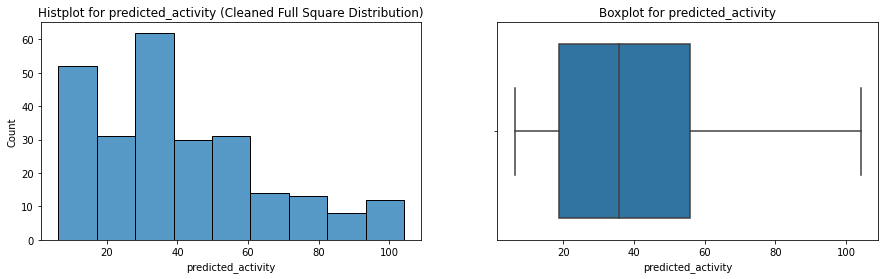

Empty DataFrame
Columns: [Unnamed: 0, SMILES, predicted_activity]
Index: []
Total outliers - 0


In [52]:
box_histplot(final_df, 'predicted_activity')
outliers, cleaned = outliers_iqr(final_df, 'predicted_activity')
print (outliers)
print (f'Total outliers - {outliers.shape[0]}')

Чтобы оценить качество предсказаний, нужны настоящие значения активности для тестовой выборки. У меня их нет. Поэтому ограничимся вышепредставленной оценкой.

Во-первых, нет отрицательных значений. 
- RandomForest работает с любыми числами, а значит дело в том, что модель словно "не замечает" отрицательные значения. Почему?
- Видимо их мало в тренировочной выборке. Давайте глянем еще раз на процент отрицательных значений в тренировочной выборке.

In [53]:
neg = (train['activity'] < 0).sum()
pos = (train['activity'] >= 0).sum()
percent = neg*100/(neg+pos)
print(f"Отрицательных значений: {neg}")
print(f"Положительных значений: {pos}")
print(f"Процент отрицательных значений: {percent.round(2)} %")


Отрицательных значений: 49
Положительных значений: 710
Процент отрицательных значений: 6.46 %


Такая низкая доля действительно объясняет, почему Random Forest может "игнорировать" отрицательные значения в предсказаниях — особенно при усреднении по деревьям.

Варианты решения:
1) Исключить отрицательные значения вовсе, и поставить ограничение на способности предсказывать активность.
3) Почитать про методы усиления редких классов.

Так как я учусь, попробуем реализовать второй вариант.

Методы усиления:
 - Oversampling (просто и быстро)
 - Дать больший вес редким значениям (использовать не могу с RandomForest)
 - Разделить выборку на отрицательных и положительных и подобрать разные регрессионные модели (долго и требует снова подбора параметров с нуля)
 - Использовать модель с градиентным бустингом (пробовали, они дают плохую предсказательную способность в нашем задании)

 Я попробую Oversampling

In [54]:
# Отдельные подмножества
neg_samples = train[train['activity'] < 0]
pos_samples = train[train['activity'] >= 0]

# Повторим отрицательные значения до нужного размера
neg_oversampled = neg_samples.sample(n=len(pos_samples), replace=True, random_state=42)

# Объединим заново
train_balanced = pd.concat([pos_samples, neg_oversampled]).sample(frac=1, random_state=42)

In [58]:
# y_train — вектор активности из train
y_train = train_balanced.activity.values
# Преобразование SMILES из train_balanced
X_train = smiles_to_fp(train_balanced.SMILES)
# Разделяем train на обучающую и валидационную выборки
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [59]:
# Обучаем модель на тренировочных данных
model_RandomForest = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 16,
    random_state = 42)

model_RandomForest.fit(X_tr, y_tr)

# Предсказываем на валидационной выборке
y_val_pred = model_RandomForest.predict(X_val)

# Оцениваем качество
print("Валидация на hold-out части train:")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"R2: {r2_score(y_val, y_val_pred):.4f}")

Валидация на hold-out части train:
MSE: 360.4794
RMSE: 18.9863
MAE: 12.0719
R2: 0.7239


Ух ты! Получилось еще и улучшить модель. Значительно. R2 вырос на 15%, а RMSE снизилось.

Предсказываем:

   Unnamed: 0                                             SMILES  \
0           0                                           CC(O)CCO   
1           1                 CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1   
2           2  CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...   
3           3                                C=CC(=O)NCNC(=O)C=C   
4           4                         CC1=CC(=CC=C1)[N+]([O-])=O   

   predicted_activity  
0                0.28  
1               68.38  
2               49.93  
3               -0.67  
4               41.10  


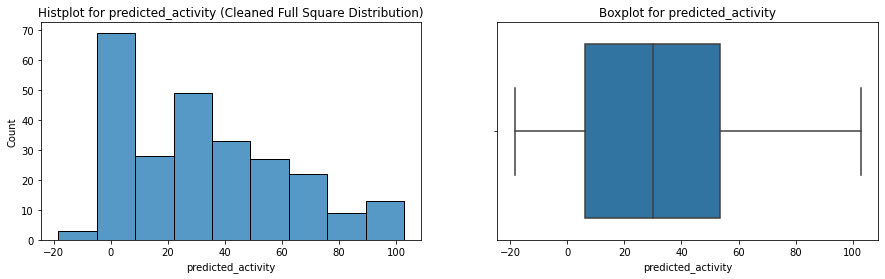

Empty DataFrame
Columns: [Unnamed: 0, SMILES, predicted_activity]
Index: []
Total outliers - 0


In [60]:
# Обучаем модель на всём обучающем наборе
model_RandomForest = RandomForestRegressor(
    n_estimators=200,
    max_depth=16,
    random_state=42
)
model_RandomForest.fit(X_train, train_balanced.activity)

# Предсказания на тестовой выборке
y_pred_test = model_RandomForest.predict(X_test)

# Создание финального датафрейма
final_df = test.copy()
final_df['predicted_activity'] = y_pred_test.round(2)

# Вывод 
print(final_df.head())

# Рассмотрим датасет
box_histplot(final_df, 'predicted_activity')
outliers, cleaned = outliers_iqr(final_df, 'predicted_activity')
print (outliers)
print (f'Total outliers - {outliers.shape[0]}')

Готово! Выгружаю получившийся датасет

In [61]:
final_df[['SMILES', 'predicted_activity']].to_csv("final_df.csv", index=False)
